In [39]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from scipy import stats, spatial
import pickle
# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# #rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)
import csv
from ast import literal_eval
from scipy import special

In [2]:
data_path = '../../data/lda_merged_chs/'

In [5]:
fandom_list = [i for i in os.listdir(data_path) if 'tsv' in i]

In [23]:
def create_timelist(df):
    df = df.fillna(0)
    timelist = df.PublishDate.drop_duplicates().tolist()
    timelist = [str(i)[:7] for i in timelist]
    timelist = [item for item in timelist if int(item[0:4]) >= 2009]
    return sorted(list(set(timelist)))

In [24]:
def create_df_time(df, time_window):
    dfs = []
    for time in time_window:
        dfs.append(df[df.PublishDate.str[:7] == time])
    return pd.concat(dfs)


In [37]:
def JSD(P, Q):
    M = 0.5 * (P + Q)
    return 0.5 * (sum(special.rel_entr(P, M)) + sum(special.rel_entr(Q, M)))

In [42]:
df_all = []
for fandom in fandom_list:
    df = pd.read_csv(os.path.join(data_path,fandom), sep = '\t', quoting=csv.QUOTE_NONE)
    df = df.dropna(subset=['Dist'])
    df['Dist'] = df['Dist'].apply(lambda x: literal_eval(x))
    timelist = create_timelist(df)
    for time in timelist:
        prev_window = timelist[timelist.index(time)-6:timelist.index(time)]
        future_window = timelist[timelist.index(time):timelist.index(time)+6]
        if len(future_window) > 0 and len(prev_window) > 0:
            # use the current month and the next 6 months
            df_t_curr = create_df_time(df, [time])
            df_t_prev = create_df_time(df, prev_window)
            df_t_future = create_df_time(df, future_window)
            prev = df_t_prev.Dist.tolist()
            std_prev = np.mean(np.asarray(prev), axis=0)
            futu = df_t_future.Dist.tolist()
            std_futu = np.mean(np.asarray(futu), axis=0)
            df_t_curr['JSD_to_past'] = df_t_curr.apply(lambda row: JSD(row['Dist'], std_prev), axis=1)
            df_t_curr['JSD_to_future'] = df_t_curr.apply(lambda row: JSD(row['Dist'], std_futu), axis=1)
            df_all.append(df_t_curr)
df_all = pd.concat(df_all)
print(df_all.head())
    

    index                                     AdditionalTags  \
344    75                                     A/U, Crossover   
345   210  Action/Adventure, Angst, Comedy, Romance, Alte...   
346   309                             Alternate Canon, Humor   
347   693           Alternate Universe, Fisting, Kink, Angst   
348   696       Alternate Universe, Fluff, Humor, Kink, Smut   

                               ArchiveWarnings       Author  Bookmarks  \
344  Creator Chose Not To Use Archive Warnings     Dargelos        3.0   
345                  No Archive Warnings Apply      trepkos        2.0   
346                  No Archive Warnings Apply  Mad Poetess        0.0   
347                  No Archive Warnings Apply  Mad Poetess        2.0   
348                  No Archive Warnings Apply  Mad Poetess        0.0   

    Category Chapters                                         Characters  \
344    Multi        1  Buffy Summers, Faith Lehane, Abby Sciuto, Abig...   
345      M/M      

In [46]:
df_all.rename(columns={'JSD_to_past':'Novelty'}, inplace=True)

In [47]:
df_all.rename(columns={'JSD_to_future':'Transience'}, inplace=True)

In [48]:
len(df_all)

132382

In [49]:
df_all['Resonance'] = df_all['Novelty'] - df_all['Transience']

In [50]:
res = df_all['Resonance'].tolist()

In [51]:
center = int(len(df_all)/2)

In [52]:
center

66191

In [53]:
df_all.sort_values(by='Resonance').iloc[center: center+10].URL.tolist()

['http://archiveofourown.org/works/410164',
 'http://archiveofourown.org/works/4760168',
 'http://archiveofourown.org/works/5655520/chapters/13298575',
 'http://archiveofourown.org/works/1097297?view_adult=true',
 'http://archiveofourown.org/works/5869276',
 'http://archiveofourown.org/works/113702',
 'http://archiveofourown.org/works/331347/chapters/534741?view_adult=true',
 'http://archiveofourown.org/works/360061/chapters/586702',
 'http://archiveofourown.org/works/4856252/chapters/11331805',
 'http://archiveofourown.org/works/6525751?view_adult=true']

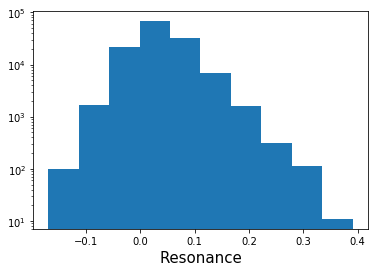

In [55]:
plt.hist(res)
plt.xlabel('Resonance', fontsize=15)
plt.yscale('log')

Text(0.5, 0, 'Resonance')

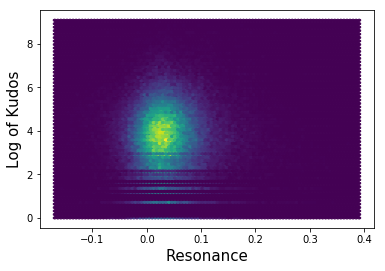

In [58]:
plt.hexbin(df_all['Resonance'].tolist(), np.log(df_all['Kudos'].tolist()))
plt.ylabel('Log of Kudos', fontsize=15)
plt.xlabel('Resonance', fontsize=15)
# plt.ylim(-0.1, 0.1)

Text(0.5, 0, 'Resonance')

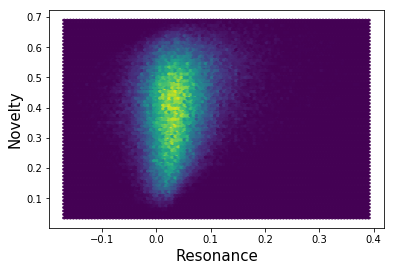

In [60]:
plt.hexbin(df_all['Resonance'].tolist(), df_all['Novelty'].tolist())
plt.ylabel('Novelty', fontsize=15)
plt.xlabel('Resonance', fontsize=15)
# plt.ylim(-0.1, 0.1)

In [40]:
stats.pearsonr(df_all['Kudos_x'].tolist(), df_all['Resonance'].tolist())

(-0.025203018772684122, 3.434449996843453e-59)

In [21]:
np.percentile(sorted(df_all['Novelty'].tolist()), [0, 25, 5, 75, 100])

array([0.05655838, 0.27845869, 0.16024989, 0.84121726, 0.9974296 ])

/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


Text(0.5, 1.0, 'High novelty')

/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


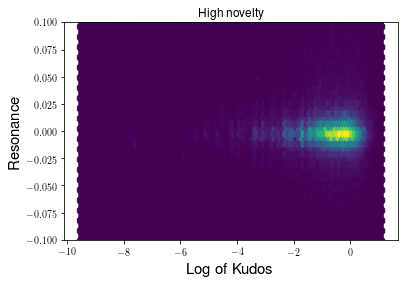

In [22]:
top_novelty = df_all[df_all['Novelty'] >= 0.841]
plt.hexbin(np.log(top_novelty['Kudos_x'].tolist()), top_novelty['Resonance'].tolist())
plt.xlabel('Log of Kudos', fontsize=15)
plt.ylabel('Resonance', fontsize=15)
plt.ylim(-0.1, 0.1)
plt.title('High novelty')

/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


Text(0.5, 1.0, 'Low novelty')

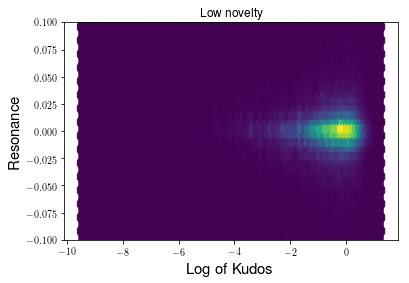

In [37]:
tail_novelty = df_all[df_all['Novelty'] <= 0.278]
plt.hexbin(np.log(tail_novelty['Kudos_x'].tolist()), tail_novelty['Resonance'].tolist())
plt.xlabel('Log of Kudos', fontsize=15)
plt.ylabel('Resonance', fontsize=15)
plt.ylim(-0.1, 0.1)
plt.title('Low novelty')

In [24]:
def var_bootstrap_resample(li):
    if len(li) > 0:
        var_original = np.var(li)
        var_s = []
        for i in range(100):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            var_s.append(np.var(sample))
        tail = sorted(var_s)[5]
        head = sorted(var_s)[95]
        return (var_original, tail, head)

In [25]:
def ave_bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        ave_s = []
        for i in range(100):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            ave_s.append(np.average(sample))
        tail = sorted(ave_s)[5]
        head = sorted(ave_s)[95]
        return (ave_original, tail, head)

In [26]:
def create_dict(df, resonance_field, suc_field):
    
    # Make bins
    df[resonance_field] = df[resonance_field].astype(float)
    term_n = sorted(df[resonance_field].tolist())
    term_n = np.quantile(term_n, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    term_n = np.insert(term_n, 0, 0)
    term_n = np.concatenate([term_n, [1]])
    dic = {}
    for i in range(len(term_n)-1):
        df_s = df[(df[resonance_field] >= term_n[i]) & (df[resonance_field] < term_n[i+1])]
        li = df_s[suc_field].tolist()
        if len(li) > 0:
            dic[term_n[i]] = ave_bootstrap_resample(li)
    return dic

In [27]:
def generate_res(df, resonance_field, suc_field):
    
    df = df.sort_values(by = resonance_field)
    df = df.sort_values(by = suc_field)
    dic = create_dict(df, resonance_field, suc_field)

    return dic
    

In [28]:
resonance_kudos_dict_var = generate_res(df_all, 'Resonance', 'Kudos_x')

In [29]:
resonance_kudos_dict_var

{-0.024486895199449514: (0.052318444275704215,
  0.04371825948075508,
  0.05949391619054278),
 -0.013813791909704375: (0.05220585286659595,
  0.0450210451291504,
  0.05951149415562555),
 -0.008280528053707659: (0.027929161480136595,
  0.020282697709259216,
  0.0383424008266081),
 -0.004410606143675651: (0.0016426957357061581,
  -0.005587340296876858,
  0.008694486340515954),
 -0.0011721725630045032: (-0.02814932978506411,
  -0.03583597303615235,
  -0.020891257287510512),
 0.0019944383088459786: (-0.04412593727828002,
  -0.05284498353341345,
  -0.0358102078587255),
 0.0056972644268100305: (-0.05455154143891778,
  -0.06311844855100533,
  -0.04674713237557317),
 0.010876350480529033: (-0.062396208040199214,
  -0.0710266305774674,
  -0.05467538310613835),
 0.02097422269336817: (-0.1087862581825078,
  -0.11798576284613509,
  -0.09884546342803502)}

In [30]:
# pickle.dump(resonance_kudos_dict_var, open('resonance_kudos_dict_var.p', 'wb'))

In [31]:
# tfidf_kudos_dict_var = pickle.load(open('tfidf_kudos_dict_var.p', 'rb'))

In [32]:
def create_xs(keys):
    xs = []
    for i in range(len(keys)-1):
        xs.append(keys[i] + (keys[i+1] - keys[i])/2)
    return xs

In [33]:
def extract_plot_vals(dic):
    keys = sorted(dic.keys())
    x = create_xs(keys)
    y = [dic[j][0] for j in keys[:-1]]
    lower_error = [dic[j][0] - dic[j][1] for j in keys[:-1]]
    upper_error = [dic[j][2] - dic[j][0] for j in keys[:-1]]
    asymmetric_error = [lower_error, upper_error]
    return x,y,asymmetric_error

Text(0, 0.5, 'Kudos')

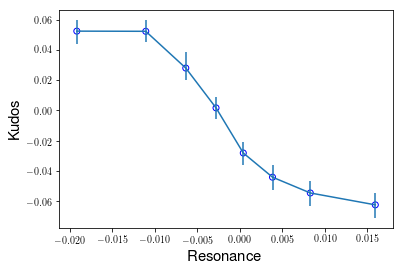

In [36]:
fig = plt.figure()
# fig.subplots_adjust(bottom = 0.4)


plt.subplot(1, 1, 1)

x, y, err = extract_plot_vals(resonance_kudos_dict_var)
plt.errorbar(x, y, yerr=err)
plt.scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='blue')
plt.xlabel('Resonance', fontsize=15)
plt.ylabel('Kudos', fontsize=15)